# Part A

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from random import randint 
import pandas as pd
import keras
from tqdm import tqdm
from keras.models import Sequential, Model
from keras.layers import Input, Dense, BatchNormalization, Dropout, Flatten
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.layers import ELU, PReLU, LeakyReLU
from keras.optimizers import Adam, SGD
from keras.initializers import RandomNormal
from keras.backend import clear_session
np.random.seed(0)
import tensorflow as tf
import tensorflow.keras.backend as K

In [5]:
def loading_data(name) : 
   filename = name+'.npy'
   return np.load(filename)

In [6]:
bus_data = np.load('bus.npy')

Ploting code

In [7]:
def plot_image(image):
 plt.imshow(image, cmap="binary")
 plt.axis("on")
def show_reconstructions(model, n_images , X_valid):
 reconstructions = model.predict(X_valid[:n_images])
 fig = plt.figure(figsize=(n_images * 1.5, 3))
 for image_index in range(n_images):
  plt.subplot(2, n_images, 1 + image_index)
  plot_image(X_valid[image_index].reshape(28,28))
  plt.subplot(2, n_images, 1 + n_images + image_index)
  plot_image(reconstructions[image_index])

In [8]:

def randomize (arr, n):
    for i in range(n-1,0,-1):
        j = randint(0,i+1)
        arr[i],arr[j] = arr[j],arr[i]
    return arr

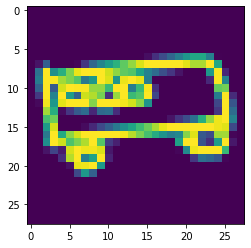

In [10]:
X_train = (bus_data.astype(np.float32)/127.5) - 1. #normalize to be [-1,1]
num_train = X_train.shape[0]
X_train = X_train.reshape(num_train, 28, 28, 1)
random_bus = X_train[np.random.randint(num_train-1)].reshape(28, 28)
random_bus = random_bus*127.5 + 1
plt.imshow(random_bus) 

In [11]:
num_train = X_train.shape[0]
X_train = X_train.reshape(num_train, 28, 28, 1)
X_train_valid=X_train[:int(0.1*len(X_train))]

In [41]:
class Sampling(keras.layers.Layer):
 def call(self, inputs):
  mean, log_var = inputs
  return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

In [42]:

def Model_Creator_Variational_Auto_Encoder(size_of_input_vector_encoding  , X_train , X_train_valid , n_epochs = 2) :
          codings_size = size_of_input_vector_encoding
          inputs = keras.layers.Input(shape=[28, 28])
          z = keras.layers.Flatten()(inputs)
          z = keras.layers.Dense(150, activation="selu")(z)
          z = keras.layers.Dense(100, activation="selu")(z)
          codings_mean = keras.layers.Dense(codings_size)(z) # μ
          codings_log_var = keras.layers.Dense(codings_size)(z) # γ
          codings = Sampling()([codings_mean, codings_log_var])
          variational_encoder = keras.Model(
          inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

          decoder_inputs = keras.layers.Input(shape=[codings_size])
          x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
          x = keras.layers.Dense(150, activation="selu")(x)
          x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
          outputs = keras.layers.Reshape([28, 28])(x)  


          variational_decoder = keras.Model(inputs=[decoder_inputs], outputs=[outputs])
          _ , _, codings = variational_encoder(inputs)
          reconstructions = variational_decoder(codings)
          variational_ae = keras.Model(inputs=[inputs], outputs=[reconstructions])
          latent_loss = -0.5 * K.sum(
          1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
          axis=-1)
          variational_ae.add_loss(K.mean(latent_loss) / 784.)
          variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop")
          history = variational_ae.fit(X_train, X_train, epochs= n_epochs, batch_size=128,validation_data=[X_train_valid, X_train_valid]) 
          return variational_ae


## We Have Created the Model for generating a doodle given an input vector (encoding) of 5 dimensions.

In [43]:
model = Model_Creator_Variational_Auto_Encoder(5 ,X_train  ,X_train_valid )


Epoch 1/2
1299/1299 [==============================] - 13s 9ms/step - loss: -9.6886 - val_loss: -10.0622
Epoch 2/2
1299/1299 [==============================] - 8s 6ms/step - loss: -10.1148 - val_loss: -10.1518


In [44]:
model.summary()

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 28, 28)]     0           []                               
                                                                                                  
 model_21 (Functional)          [(None, 5),          133860      ['input_15[0][0]']               
                                 (None, 5),                                                       
                                 (None, 5)]                                                       
                                                                                                  
 model_22 (Functional)          (None, 28, 28)       134134      ['model_21[0][2]']               
                                                                                           

1/1 [==============================] - 0s 142ms/step


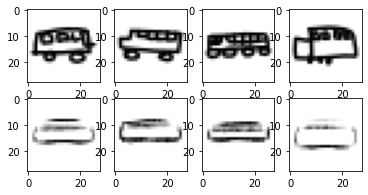

In [45]:
show_reconstructions(model , 4 , X_train_valid)

<H1> increasing the dimension from 5 to 10

In [46]:
model_bus_10 = Model_Creator_Variational_Auto_Encoder( 10  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 10s 7ms/step - loss: -9.7759 - val_loss: -10.1137
Epoch 2/2
1299/1299 [==============================] - 9s 7ms/step - loss: -10.2196 - val_loss: -10.2767


1/1 [==============================] - 0s 110ms/step


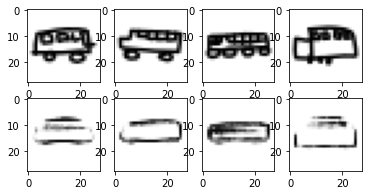

In [47]:
show_reconstructions(model_bus_10 , 4 , X_train_valid)

<H2><b> Increasing the input vector encoding dimension further to 25 </b></H2>

In [48]:
model_bus_25 = Model_Creator_Variational_Auto_Encoder( 25  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 10s 7ms/step - loss: -9.8132 - val_loss: -10.1821
Epoch 2/2
1299/1299 [==============================] - 9s 7ms/step - loss: -10.2844 - val_loss: -10.3507


1/1 [==============================] - 0s 136ms/step


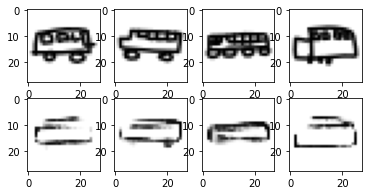

In [49]:
show_reconstructions(model_bus_25 , 4 , X_train_valid)

<H1> <b> Image Quality has further Improved Lets Increase the number of dimesion furether to 50 </b></H1>

In [50]:
model_bus_75 = Model_Creator_Variational_Auto_Encoder( 75  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 11s 8ms/step - loss: -9.8341 - val_loss: -10.1637
Epoch 2/2
1299/1299 [==============================] - 12s 9ms/step - loss: -10.2710 - val_loss: -10.3080


1/1 [==============================] - 0s 130ms/step


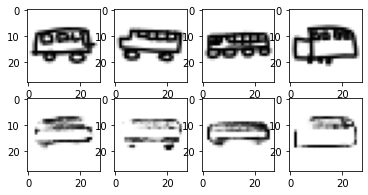

In [51]:
show_reconstructions(model_bus_75 , 4 , X_train_valid)

In [52]:
model_bus_50 = Model_Creator_Variational_Auto_Encoder( 50  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 14s 10ms/step - loss: -9.7829 - val_loss: -10.1450
Epoch 2/2
1299/1299 [==============================] - 13s 10ms/step - loss: -10.2599 - val_loss: -10.3389


1/1 [==============================] - 0s 141ms/step


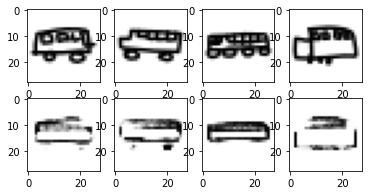

In [53]:
show_reconstructions(model_bus_50 , 4 , X_train_valid)

<h1><b> Lets Try for 100 dim </b></h1>

In [54]:
model_bus_100 = Model_Creator_Variational_Auto_Encoder( 100  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 15s 11ms/step - loss: -9.7129 - val_loss: -10.0337
Epoch 2/2
1299/1299 [==============================] - 13s 10ms/step - loss: -10.1735 - val_loss: -10.2701


1/1 [==============================] - 0s 180ms/step


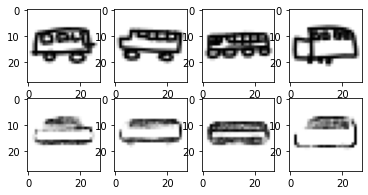

In [55]:
show_reconstructions(model_bus_100 , 4 , X_train_valid)

<H1><b> Hundered is Till now the best lets Further Try to increase the dimension to 200 </b></H1>

In [56]:
model_bus_200 = Model_Creator_Variational_Auto_Encoder( 200  ,X_train  ,X_train_valid )

Epoch 1/2
1299/1299 [==============================] - 16s 12ms/step - loss: -9.7396 - val_loss: -10.0583
Epoch 2/2
1299/1299 [==============================] - 14s 11ms/step - loss: -10.1733 - val_loss: -10.2653


1/1 [==============================] - 0s 30ms/step


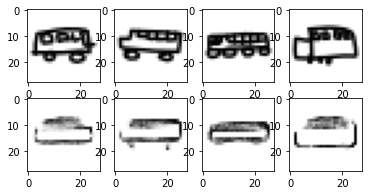

In [57]:
show_reconstructions(model_bus_100 , 4 , X_train_valid)

In [58]:
def PreProcessing(Data) : 
      doodles = Data 
      X_train = (doodles.astype(np.float32)/127.5) - 1. #normalize to be [-1,1]
      num_train = X_train.shape[0] 
       
      X_train = X_train.reshape(num_train, 28, 28, 1)
      X_valid=X_train[:int(0.1*len(X_train))]
      random_bus = X_train[0].reshape(28, 28)
      if num_train  > 1 : 
        random_bus = X_train[np.random.randint(num_train-1)].reshape(28, 28)
      random_bus = random_bus*127.5 + 1
      plt.imshow(random_bus) #a wild random cat appears
      num_train = X_train.shape[0]
      X_train = X_train.reshape(num_train, 28, 28, 1)
      # print(type(X_train),type(X_train_valid))
      X_train_valid=X_train[:int(0.1*len(X_train))] 
      return (X_train , X_train_valid)
            

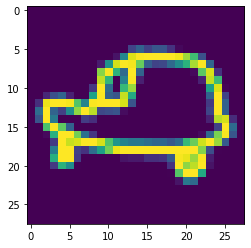

In [59]:
data = loading_data('car')
x_train , x_train_valid = PreProcessing(data) 


In [60]:

model_car_100  = Model_Creator_Variational_Auto_Encoder(100 , x_train , x_train_valid)

Epoch 1/2
1428/1428 [==============================] - 15s 10ms/step - loss: -10.4531 - val_loss: -10.6428
Epoch 2/2
1428/1428 [==============================] - 18s 13ms/step - loss: -10.7598 - val_loss: -10.8683


1/1 [==============================] - 0s 172ms/step


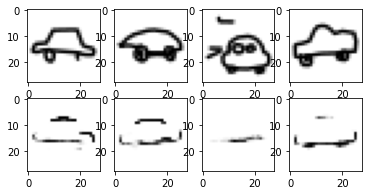

In [61]:
show_reconstructions(model_car_100 , 4 , x_train_valid)

<H1><b>Generating a model for aircraft<b></h1>

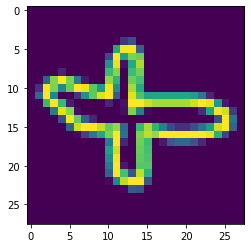

In [63]:
data = loading_data('airplane')
x_train , x_train_valid = PreProcessing(data) 

In [64]:

model_aircraft_100  = Model_Creator_Variational_Auto_Encoder(500 , x_train , x_train_valid)

Epoch 1/2
1185/1185 [==============================] - 20s 16ms/step - loss: -10.4892 - val_loss: -10.6473
Epoch 2/2
1185/1185 [==============================] - 19s 16ms/step - loss: -10.7359 - val_loss: -10.8671


1/1 [==============================] - 0s 119ms/step


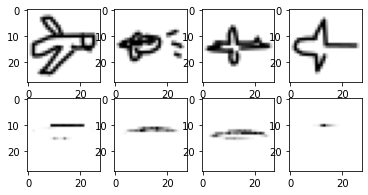

In [65]:
show_reconstructions(model_aircraft_100 , 4 , x_train_valid)

<h1><b>  Generating Model for Trucks </b> </h1>

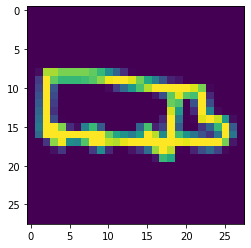

In [66]:
data = loading_data('truck')
x_train , x_train_valid = PreProcessing(data) 

In [67]:

model_trucks_100  = Model_Creator_Variational_Auto_Encoder(100 , x_train , x_train_valid , 15)

Epoch 1/15
1027/1027 [==============================] - 11s 10ms/step - loss: -10.3536 - val_loss: -10.5703
Epoch 2/15
1027/1027 [==============================] - 12s 11ms/step - loss: -10.6478 - val_loss: -10.6915
Epoch 3/15
1027/1027 [==============================] - 11s 11ms/step - loss: -10.7596 - val_loss: -10.8100
Epoch 4/15
1027/1027 [==============================] - 11s 11ms/step - loss: -10.8476 - val_loss: -10.8766
Epoch 5/15
1027/1027 [==============================] - 11s 11ms/step - loss: -10.9256 - val_loss: -10.9586
Epoch 6/15
1027/1027 [==============================] - 13s 12ms/step - loss: -11.0023 - val_loss: -11.0432
Epoch 7/15
1027/1027 [==============================] - 12s 12ms/step - loss: -11.0636 - val_loss: -11.0831
Epoch 8/15
1027/1027 [==============================] - 15s 15ms/step - loss: -11.1044 - val_loss: -11.1033
Epoch 9/15
1027/1027 [==============================] - 23s 22ms/step - loss: -11.1409 - val_loss: -11.1453
Epoch 10/15
1027/1027 [=====

3/3 [==============================] - 0s 3ms/step


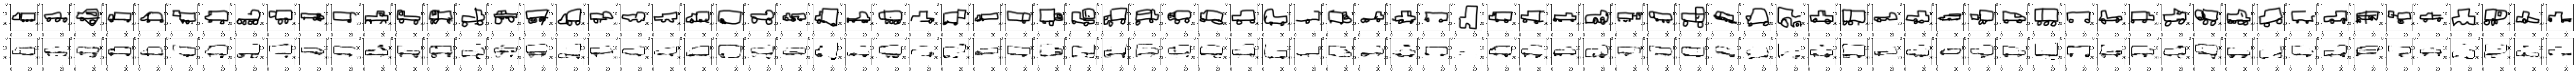

In [68]:
show_reconstructions(model_trucks_100 , 80 , x_train_valid)

<H1> <B>Generating Model for bicycle </B> </H1>

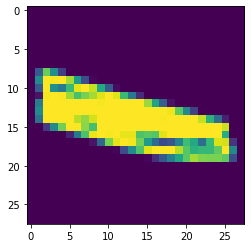

In [69]:
data = loading_data('bicycle')
x_train , x_train_valid = PreProcessing(data) 

In [70]:

model_bicycle_100  = Model_Creator_Variational_Auto_Encoder(100 , x_train , x_train_valid)

Epoch 1/2
989/989 [==============================] - 10s 9ms/step - loss: -10.1910 - val_loss: -10.4257
Epoch 2/2
989/989 [==============================] - 9s 9ms/step - loss: -10.5056 - val_loss: -10.6037


1/1 [==============================] - 0s 129ms/step


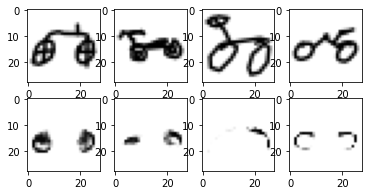

In [71]:
show_reconstructions(model_bicycle_100 , 4 , x_train_valid)

# Part B

<H1><b> Here we will be needing to generate mixture of Data for Generating some mixture of images <b></H1>

In [72]:
def mix_data(DataSet1 , DataSet2) : 
        DataSet1 =  list(DataSet1)
        DataSet2 =  list(DataSet2) 
        DataSet2  = randomize(DataSet2 , len(DataSet2))
        for i in DataSet2 : 
             DataSet1.append(i)
        return np.array(randomize(DataSet1 , len(DataSet1))) 

In [73]:

def  MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_  , n = 1 ) :
          mean = []
          while n :
            num_train = X_train.shape[0] 
            random_bus1 = X_train[np.random.randint(num_train-1)].reshape(28, 28)
            num_train = X_train.shape[0] 
            random_bus2 = X_train_[np.random.randint(num_train-1)].reshape(28, 28) 
            mean .append((random_bus1+random_bus2)/2)
            n-=1
          return mean
      

          


In [74]:
import pandas as pd

<i><h2> Lets try mixing the car and airplane dataset </i></h2>

Epoch 1/5
2613/2613 [==============================] - 63s 23ms/step - loss: -10.5809 - val_loss: -10.8465
Epoch 2/5
2613/2613 [==============================] - 34s 13ms/step - loss: -10.9772 - val_loss: -11.0591
Epoch 3/5
2613/2613 [==============================] - 69s 26ms/step - loss: -11.1122 - val_loss: -11.1399
Epoch 4/5
2613/2613 [==============================] - 38s 15ms/step - loss: -11.1752 - val_loss: -11.1929
Epoch 5/5
2613/2613 [==============================] - 36s 14ms/step - loss: -11.2177 - val_loss: -11.2139


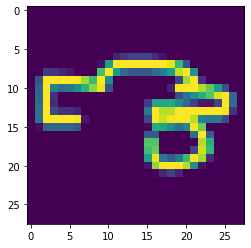

In [75]:

data1 = loading_data('car')
data2 = loading_data('airplane')
Mixed_DataSet = mix_data(data1 , data2)
X_train , X_train_valid = PreProcessing(data1) 
X_train_ , X_train_valid_ = PreProcessing(data2)
reconstruct1 = MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_)
Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Mixed_DataSet)
mix_airplane_car = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5)



In [76]:
print(reconstruct1)

[array([[-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.92941177,
        -0.7254902 , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        ],
       [-1.        , -1.        , -1.        , -1.        , -1.        ,
        -1.        , -1.        , -1.        , -1.        , -0.5372549 ,
         0.        , -0.439

1/1 [==============================] - 0s 152ms/step


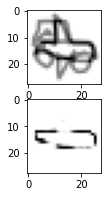

In [77]:
X_train = np.array(reconstruct1)
show_reconstructions(mix_airplane_car , 1 , X_train)

Lets try mixing Truck and Bus

Epoch 1/5
2325/2325 [==============================] - 32s 13ms/step - loss: -10.1715 - val_loss: -10.4829
Epoch 2/5
2325/2325 [==============================] - 28s 12ms/step - loss: -10.6183 - val_loss: -10.7240
Epoch 3/5
2325/2325 [==============================] - 35s 15ms/step - loss: -10.7815 - val_loss: -10.8166
Epoch 4/5
2325/2325 [==============================] - 57s 25ms/step - loss: -10.8559 - val_loss: -10.8565
Epoch 5/5
2325/2325 [==============================] - 53s 23ms/step - loss: -10.9010 - val_loss: -10.9111


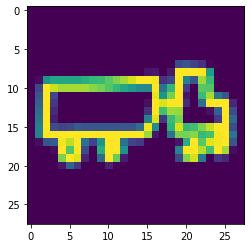

In [78]:
data1 = loading_data('truck')
data2 = loading_data('bus')
Mixed_DataSet = mix_data(data1 , data2)
X_train , X_train_valid = PreProcessing(data1) 
X_train_ , X_train_valid_ = PreProcessing(data2)
reconstruct1 = MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_  ,5 )
Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Mixed_DataSet)
mix_truck_bus = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5)

1/1 [==============================] - 0s 380ms/step


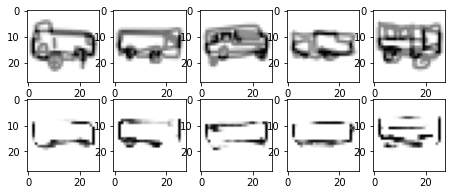

In [79]:
X_train = np.array(reconstruct1)
show_reconstructions(mix_truck_bus , 5 , X_train)

<H1 ><i> Lets Mix Car and Bicycle </i></H1>

Epoch 1/5
2417/2417 [==============================] - 36s 13ms/step - loss: -10.4343 - val_loss: -10.6684
Epoch 2/5
2417/2417 [==============================] - 39s 16ms/step - loss: -10.8001 - val_loss: -10.8938
Epoch 3/5
2417/2417 [==============================] - 48s 20ms/step - loss: -10.9572 - val_loss: -11.0098
Epoch 4/5
2417/2417 [==============================] - 26s 11ms/step - loss: -11.0386 - val_loss: -11.0821
Epoch 5/5
2417/2417 [==============================] - 27s 11ms/step - loss: -11.0960 - val_loss: -11.1137


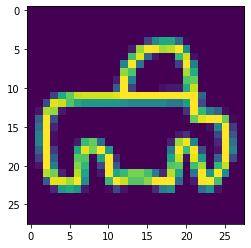

In [80]:
data1 = loading_data('car')
data2 = loading_data('bicycle')
Mixed_DataSet = mix_data(data1 , data2)
X_train , X_train_valid = PreProcessing(data1) 
X_train_ , X_train_valid_ = PreProcessing(data2)
reconstruct1 = MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_ , 5)
Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Mixed_DataSet)
mix_car_cycle = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5)

1/1 [==============================] - 0s 235ms/step


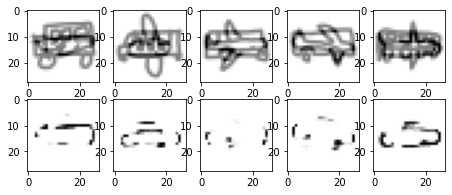

In [87]:
X_train = np.array(reconstruct1)
show_reconstructions(mix_car_cycle , 5 , X_train)

<H1 ><i> Lets Mix bus  and Airplane </i></H1>

Epoch 1/5
2484/2484 [==============================] - 23s 9ms/step - loss: -10.2973 - val_loss: -10.5309
Epoch 2/5
2484/2484 [==============================] - 27s 11ms/step - loss: -10.7288 - val_loss: -10.7616
Epoch 3/5
2484/2484 [==============================] - 23s 9ms/step - loss: -10.8650 - val_loss: -10.8559
Epoch 4/5
2484/2484 [==============================] - 21s 8ms/step - loss: -10.9228 - val_loss: -10.8654
Epoch 5/5
2484/2484 [==============================] - 23s 9ms/step - loss: -10.9583 - val_loss: -10.9022


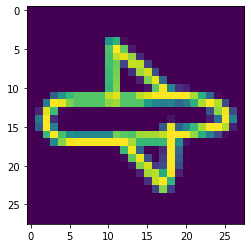

In [88]:
data1 = loading_data('airplane')
data2 = loading_data('bus')
Mixed_DataSet = mix_data(data1 , data2)
X_train , X_train_valid = PreProcessing(data1) 
X_train_ , X_train_valid_ = PreProcessing(data2)
reconstruct1 = MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_ , 5)
Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Mixed_DataSet)
mix_truck_bus = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5)

1/1 [==============================] - 0s 40ms/step


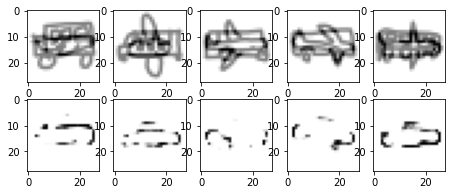

In [84]:
X_train = np.array(reconstruct1)
show_reconstructions(mix_car_cycle , 5 , X_train)

<H1> <i> Lets  Mix Bicylce and Airplane </i></H1>

Epoch 1/5
2174/2174 [==============================] - 20s 9ms/step - loss: -10.4991 - val_loss: -10.7521
Epoch 2/5
2174/2174 [==============================] - 19s 9ms/step - loss: -10.8733 - val_loss: -10.9202
Epoch 3/5
2174/2174 [==============================] - 20s 9ms/step - loss: -11.0122 - val_loss: -11.0129
Epoch 4/5
2174/2174 [==============================] - 157s 72ms/step - loss: -11.0838 - val_loss: -11.0570
Epoch 5/5
2174/2174 [==============================] - 20s 9ms/step - loss: -11.1257 - val_loss: -11.0829


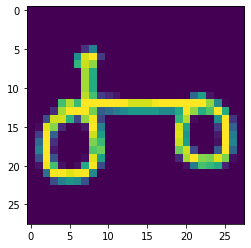

In [91]:
data1 = loading_data('airplane')
data2 = loading_data('bicycle')
Mixed_DataSet = mix_data(data1 , data2)
X_train , X_train_valid = PreProcessing(data1) 
X_train_ , X_train_valid_ = PreProcessing(data2)
reconstruct1 = MeanImageGenerator( X_train , X_train_valid ,X_train_ , X_train_valid_ , 5)
Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Mixed_DataSet)
mix_truck_bus = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5)

1/1 [==============================] - 0s 23ms/step


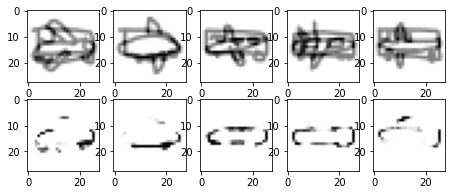

In [90]:
X_train = np.array(reconstruct1)
show_reconstructions(mix_car_cycle , 5 , X_train)

## PART3

In [92]:
def  meanImg( data1  , data2  , data3  , data4   , data5 ) :
          mean = []
          n = 5
          data = [data1  , data2  , data3  , data4   , data5 ] 
          index  =  0 
          max_len = 0
          j = 0 
          for  i in data : 
            if(len(i) > max_len):  
                max_len =  max(max_len , len(i))
                index =  j
            j+=1 
          mean = data[index]
          j = 0 ; 
          mean  = np.array(mean)
          arr = []
          for i in mean  : 
              arr.append(mean[j].reshape(28 , 28)) 
              j+=1 
          j = 0 
          mean =  arr
          for  i in data  : 
               l = 0
               if(j ==  index) : 
                   continue 
               for k in i  :   
                   mean[l] = mean[l] + k.reshape(28 , 28)
                   l+=1
               j+=1
               mean = randomize(list(mean) , len(mean)) 
               mean  = np.array(mean)
          return mean
                  
                           
       

In [93]:
def thisMuchData(DataSet , n) : 
    temp = randomize(list(DataSet) , len(DataSet)) 
    return temp[ : int(len(DataSet) *(n/100))]


In [94]:
def thisMuchData_For_image(DataSet , n) : 
    temp = randomize(list(DataSet) , len(DataSet)) 
    return temp[ : int(1000*(n/100))]

In [95]:
def dataSet(car , aircraft  , bicycle , bus  , truck ): 
       data1 = loading_data('car')
       data2 = loading_data('aircraft')
       data3 = loading_data('bicycle')
       data4 = loading_data('bus')
       data5 = loading_data('truck')  
        

       temp = thisMuchData(  list (data1) ,   car) 
       temp += thisMuchData( list (data2) , aircraft)
       temp += thisMuchData( list (data3), bicycle)
       temp += thisMuchData( list (data4) , truck)
       temp += thisMuchData( list (data5) , bus) 
       temp = randomize(temp , len(temp))
       
       
       data1  = list(data1)
       data2  = list(data2)
       data3  = list(data3)
       data4  = list(data4)
       data5  = list(data5)
       
       data1 = thisMuchData_For_image(data1 , car)
       data2 = thisMuchData_For_image(data2 , aircraft)
       data3 = thisMuchData_For_image(data3 , bicycle)
       data4  = thisMuchData_For_image(data4 , truck)
       data5  = thisMuchData_For_image(data5 , bus)

       data1  , _  = PreProcessing(np.array(data1))
       data2  , _  = PreProcessing(np.array(data2))
       data3  , _  = PreProcessing(np.array(data3))
       data4  , _  = PreProcessing(np.array(data4))
       data5  , _  = PreProcessing(np.array(data5)) 
       

       print(type(data1))
       

       randomImage =  meanImg( data1 ,data2 ,data3 ,data4 , data5 )

       
       return np.array(temp)  , randomImage

In [96]:
def Generate_MY_Doodle(Data , images):  
      print(len(Data))
      Mixed_DataSet_train   , Mixed_Dataset_valid =  PreProcessing(Data)
      mix_ = Model_Creator_Variational_Auto_Encoder(100  , Mixed_DataSet_train , Mixed_Dataset_valid , 5) 
      X_train = np.array(images)
      show_reconstructions(mix_ , 5 , X_train)

In [1]:
print("---------Hi ^v^ Lets Doodle SomeThing---------------")
# print("Abhay")
bus = input("How much your Doodle Should Have Bus like feature ->")
# print("Singh")
aircraft = input("How much your Doodle Should Have aircraft like feature ->")
truck = input("How much your Doodle Should Have truck  like feature ->")
car = input("How much your Doodle Should Have car like feature ->")
bicycle = input("How much your Doodle Should Have bicycle like feature ->")
DataSet , images =  dataSet(int(car) ,int(aircraft)  ,int (bicycle) , int(bus)  ,int( truck) )
Generate_MY_Doodle(DataSet , images)


---------Hi ^v^ Lets Doodle SomeThing---------------
Abhay
